This notebook maps SDWIS, USGS GU and USGS model predictions data sets

In [26]:
import numpy as np
import pandas as pd
import geopandas as gp
import matplotlib.pyplot as plt
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

'sdwis' includes data from 4 quarters. Dupicated for PWS ID, Facility ID and treatment process were dropped. Included facilities with Facility Activity Status = Active/Inactive

USGS GUs are based on places- Has assigned PWS IDs/Seller PWS IDs and WSA IDs

DPC has WSA 

Goal of this flow sheet is to map PWS ID from the SDWIS data set to the WSA ID using the USGS GU data set. Map the per capita consumption to the WSA ID using the DPC data set

In [38]:
# df_latest_2 has sdwis data for all 4 quarters and drops duplicates
PATH = r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024'
sdwis = pd.read_csv(PATH + '\df_latest_2.csv',low_memory=False)

# Reading the USGS v1_GU_wWS file and converting to a dataframe
usgs_gu_wwsa = gp.read_file(PATH + r'\V1_GU_wWS\v1_GU_wWS.shp')
usgs_gu_wwsa_df = pd.DataFrame(usgs_gu_wwsa.drop(columns='geometry'))

# Reading Machine learning model output for domestic demand per capita and filtering for the year 2020
dpc_2020 = pd.read_csv(PATH + r'\delivery_water_use_model\predictions\national_dpc_predictions.csv')
dpc_2020 = dpc_2020.loc[dpc_2020['year']==2020].copy()

In [39]:
# Drop rows with duplicate PWS ID, Facility ID and treatment process
sdwis_filtered = sdwis[['PWS ID','Facility Id','PWS Name', 'Population Served Count', 
                        'Activity Status', 'Facility Activity', 'Primary Source', 'PWS Type',
                        'Treatment Process','Treatment Objective']].drop_duplicates(subset = ['PWS ID','Facility Id','Treatment Process'])

# Remove rows without a treatment process listed
sdwis_filtered = sdwis_filtered.dropna(subset=['Treatment Process'])

# Remove PWS ID and Facility with only 1 treatment process
sdwis_filtered = sdwis_filtered.groupby(['PWS ID','Facility Id']).filter(lambda x: len(x['Treatment Process'])>1).reset_index()

# Filter for where population served is 0
# sdwis_filtered = sdwis_filtered[sdwis_filtered['Population Served Count']>0]
# usgs_gu_wwsa_df  = usgs_gu_wwsa_df[usgs_gu_wwsa_df['GU_POP']>0]

# Update the USGS DPC data to be upper case if it is alphanumeric
updated_column_list = []
avg_dpc = []

for idx,row in dpc_2020.iterrows():
    try:
        a = int(row['wsa_agidf'])
        updated_column_list.append(str(f'{a:09d}'))
    except:
        updated_column_list.append(row['wsa_agidf'].upper())

    avg_dpc.append(row.iloc[5::].mean())

dpc_2020['wsa_agidf'] = updated_column_list
dpc_2020['avg_dpc'] = np.array(avg_dpc)*0.00378541  # converting gallons/person/year to m3/person/year

In [40]:
# Get unique PWS IDs in SDWIS data set
sdwis_pws_ids = sdwis_filtered['PWS ID'].unique()

# Get unique PWS IDs/Seller PWS ID in USGS GU dataset 
usgs_pws_ids = usgs_gu_wwsa_df['PWS_ID'].unique()
usgs_seller_pws_ids = usgs_gu_wwsa_df['SELLER_PWS'].dropna().unique()

combined_pws_ids = np.unique(np.concatenate([usgs_seller_pws_ids,usgs_pws_ids]))
# Get unique WSA ID in USGS GU dataset
usgs_wsa_ids = usgs_gu_wwsa_df['WSA_AGIDF'].unique()
# Get unique WSA ID in USGS DPC dataset
dpc_wsa_ids = dpc_2020['wsa_agidf'].unique()

print('Unique PWS_ID in SDWIS filtered (df_latest_2):', len(sdwis_pws_ids))

print('\nUSGS v1_GU-wWS')
print('Total USGS v1_GU-wWS rows:',len(usgs_gu_wwsa_df))
print('Unique PWS_ID in USGS v1_GU-wWS:', len(usgs_pws_ids))
print('Unique Seller PWS_ID in USGS v1_GU-wWS:', len(usgs_seller_pws_ids))
print('Total unique PWS IDs (with/without seller) in v1_USGS GU-wWS:', len(combined_pws_ids))
print('Unique WSA_AGIDF in USGS v1_GU-wWS:', len(usgs_wsa_ids))
print('\nUSGS DPC data:', len(dpc_wsa_ids))

Unique PWS_ID in SDWIS filtered (df_latest_2): 25264

USGS v1_GU-wWS
Total USGS v1_GU-wWS rows: 27159
Unique PWS_ID in USGS v1_GU-wWS: 21429
Unique Seller PWS_ID in USGS v1_GU-wWS: 1706
Total unique PWS IDs (with/without seller) in v1_USGS GU-wWS: 22252
Unique WSA_AGIDF in USGS v1_GU-wWS: 18807

USGS DPC data: 18807


In [35]:
# Check if all the WSA IDs are the same between the USGS GU-wWS and USGS DPC dataset
res_usgs_wsa_ids = [i for i in usgs_wsa_ids if i not in dpc_wsa_ids]
res_dpc = [i for i in dpc_wsa_ids if i not in usgs_wsa_ids]

print('In USGS v1_GU_wWs dataset but not USGS DPC:', res_usgs_wsa_ids)
print('In USGS DPC dataset but not USGS v1_GU_wWs:', res_dpc)

In USGS v1_GU_wWs dataset but not USGS DPC: ['CO0118006', 'CA3610057', 'CO0203002']
In USGS DPC dataset but not USGS v1_GU_wWs: ['CA2010009', 'CA3310018', 'CA3310025']


In [41]:
# Trying to check if USGS v1_GU_wWs dataset PWS IDs can be mapped to SDWIS df_latest dataset

usgs_check = usgs_gu_wwsa_df[['GU_ID','PLACE_FIPS','PLACE_NAME','CNTY_NM', 'STATE_NAME','GU_POP', 'WTR_TYPE_E','PWS_ID','SELLER_PWS','WSA_AGIDF']].copy()

# Check if the PWS ID or Seller PWS ID is in the SDWIS dataset
check_list = []
pws_check_list = []

for idx,row in usgs_check.iterrows():
    if row['SELLER_PWS'] in sdwis_pws_ids:
        check_list.append('Yes')
        pws_check_list.append(row['SELLER_PWS'])
    elif row['PWS_ID'] in sdwis_pws_ids:
        check_list.append('Yes')
        pws_check_list.append(row['PWS_ID'])
    elif row['WSA_AGIDF'] in sdwis_pws_ids:
        check_list.append('Yes')
        pws_check_list.append(row['WSA_AGIDF'])
    else:
        check_list.append('No')
        pws_check_list.append(row['WSA_AGIDF'])

usgs_check['pws_check'] = pws_check_list
usgs_check['In SDWIS'] = check_list

In [37]:
# Mapping usgs_check pws_check to dpc 2020 population
usgs_check_dpc = usgs_check.merge(dpc_2020[['wsa_agidf','avg_dpc_m3personyear']],left_on='WSA_AGIDF',right_on='wsa_agidf')
# usgs_check_dpc.to_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\usgs_pws_nosingletreatment_dpc.csv')

Results Summary

In [25]:
print('USGS v1_GU_wWs PWS IDs total:', len(combined_pws_ids))

print('\nNumber of rows in USGS v1_GU_wWs that were mapped to SDWIS:', len(usgs_check_dpc[usgs_check_dpc['In SDWIS']=='Yes']))
print('Number of rows in USGS v1_GU_wWs that were NOT mapped to SDWIS:', len(usgs_check_dpc[usgs_check_dpc['In SDWIS']=='No']))

usgs_check_yes = usgs_check_dpc[usgs_check_dpc['In SDWIS']=='Yes'].copy()
usgs_check_no = usgs_check_dpc[usgs_check_dpc['In SDWIS']=='No'].copy()
print('Number of unique PWS IDs/WSA IDs of the ones that were mapped to SDWIS:',len(usgs_check_dpc['pws_check'].unique()))
print('Number of unique PWS IDs of the ones that were mapped to the SDWIS:',len(usgs_check_yes['pws_check'].unique()))
print('Number of unique PWS IDs in USGS v1_GU_wWs not in SDWIS:',len(combined_pws_ids) - len(usgs_check_dpc['pws_check'].unique()) )

print('\nNumber of SDWIS PWS IDs not included in the USGS v1_GU_wWs dataset:',len(sdwis_pws_ids)-len(combined_pws_ids) )

USGS v1_GU_wWs PWS IDs total: 22252

Number of rows in USGS v1_GU_wWs that were mapped to SDWIS: 25310
Number of rows in USGS v1_GU_wWs that were NOT mapped to SDWIS: 1844
Number of unique PWS IDs/WSA IDs of the ones that were mapped to SDWIS: 18995
Number of unique PWS IDs of the ones that were mapped to the SDWIS: 17321
Number of unique PWS IDs in USGS v1_GU_wWs not in SDWIS: 3257

Number of SDWIS PWS IDs not included in the USGS v1_GU_wWs dataset: 30878


Comparing USDA and USGS Total Demand and DPC

USGS data includes withdrawals plus deliveries

In [48]:
# Using the usgs_check mapped to dpc model output file. USGS DPC units is gallons/person/year
usgs_check_dpc['total_water_demand_m3year'] = usgs_check_dpc['GU_POP']*usgs_check_dpc['avg_dpc']*0.00378541 # converting gallon to m3

# Group state wise and calculate average DPC state wise
usgs_state = usgs_check_dpc[['STATE_NAME','GU_POP','total_water_demand_m3year']].groupby('STATE_NAME').sum().reset_index()
usgs_state['state_avg_dpc'] = usgs_state['total_water_demand_m3year']/usgs_state['GU_POP']

In [51]:
# Read the USDA data set. USDA reports total demand in MGD. For 2015 it matches USGS data for DO-WDel which means withdrawals+deliveries
usda_demand = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\source files\USDA Water Demand Projections\NorESM1-M_dp_ssp2.csv',index_col=0)
pop_projection = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\pop_projection.csv')

usda_demand_2020 = usda_demand[['fips','sector','Y2020']].copy()
usda_demand_2020['state_id'] = [int(i/1000) for i in usda_demand_2020['fips']]

In [36]:
# Aggregating population state wise
pop_projection_state = pop_projection[['state_id','ssp22020']].groupby('state_id').sum().reset_index()

In [64]:
# Read state code file
state_code = pd.read_csv(r'\Users\mhardika\Documents\AMO\2050\analysis_files\state_geocode.csv')
usda_demand_2020_copy = usda_demand_2020.merge(state_code[['state_id','abbv','state']],left_on='state_id',right_on='state_id')
usda_demand_2020_copy['Y2020'] = usda_demand_2020_copy['Y2020']*3785.4118*365 # converted mgd to m3/year

usda_demand_2020_state = usda_demand_2020_copy[['state','abbv','state_id','Y2020']].groupby(['state','abbv','state_id']).sum().reset_index()
usda_demand_2020_state = usda_demand_2020_state.merge(pop_projection_state,left_on='state_id',right_on='state_id')
usda_demand_2020_state['dpc_m3personyear'] = usda_demand_2020_state['Y2020']/usda_demand_2020_state['ssp22020']

C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_14332\1927568223.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticklabels)


Text(0, 0.5, 'm3/year')

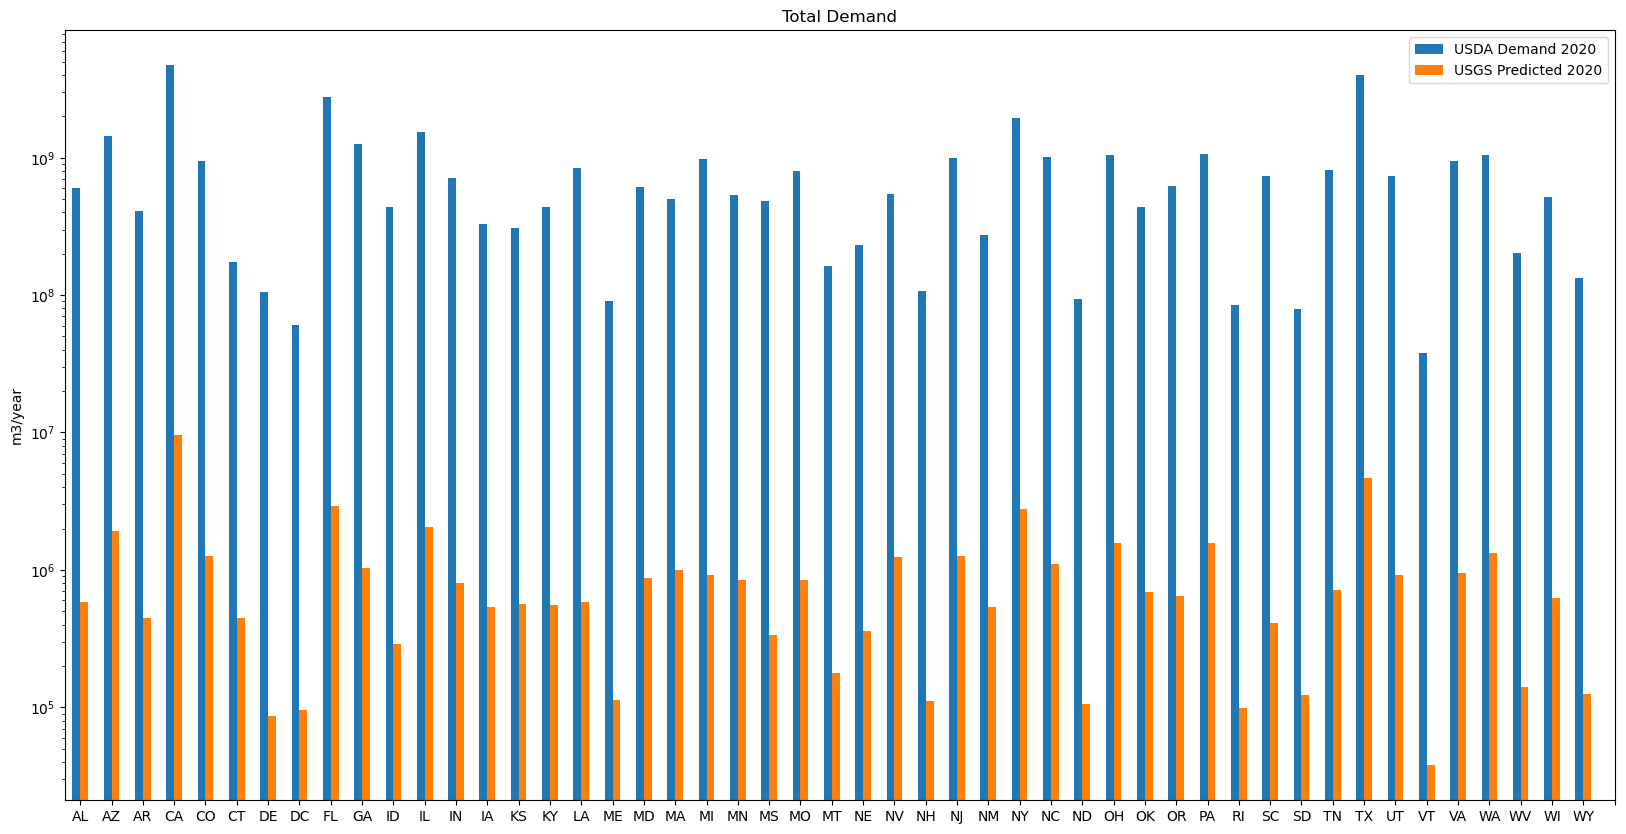

In [124]:
fig,ax = plt.subplots(figsize=(20,10))
x = np.arange(0,len(usda_demand_2020_state))*2

ax.bar(x-0.25,usda_demand_2020_state['Y2020'],width = 0.5,label='USDA Demand 2020')
ax.bar(x+0.25, usgs_state['total_water_demand_m3year'], width= 0.5,label='USGS Predicted 2020')
ax.legend()
ax.set_yscale('log')

ticklabels = ticklabels = np.concatenate(([' '],usda_demand_2020_state['abbv'],[' ']))
ax.set_xticklabels(ticklabels)
ax.xaxis.set_major_locator(plt.MaxNLocator(len(usda_demand_2020_state['abbv'])+1))
ax.set_xlim([-1,98])
ax.set_title('Total Demand')
ax.set_ylabel('m3/year')

C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_14332\4063579387.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticklabels)
C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_14332\4063579387.py:13: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim([0,1000])


Text(0, 0.5, 'm3/person/year')

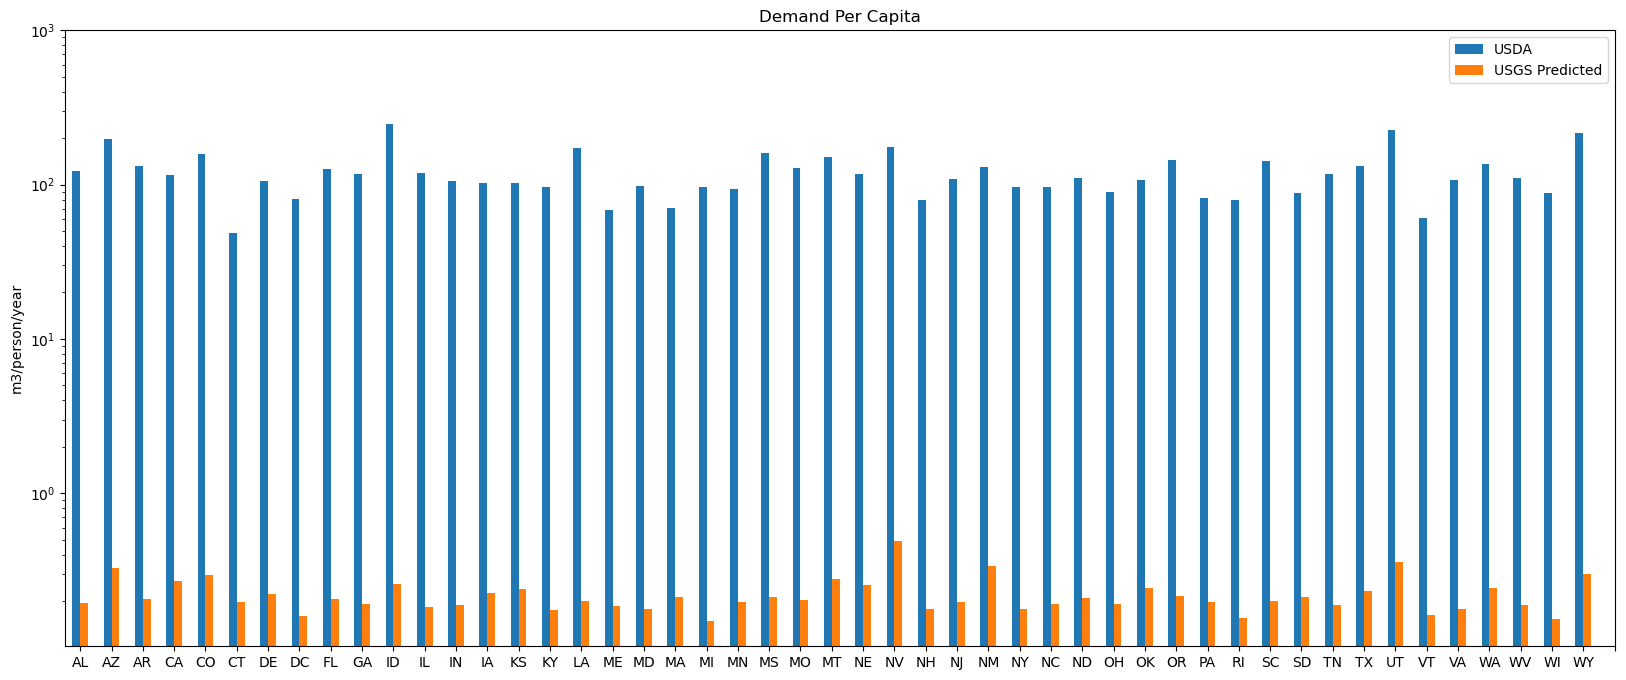

In [125]:
fig,ax = plt.subplots(figsize=(20,8))
x = np.arange(0,len(usda_demand_2020_state))*2

ax.bar(x-0.25,usda_demand_2020_state['dpc_m3personyear'],width = 0.5,label='USDA')
ax.bar(x+0.25, usgs_state['state_avg_dpc'], width= 0.5,label='USGS Predicted')
ax.legend()
ax.set_yscale('log')

ticklabels = ticklabels = np.concatenate(([' '],usda_demand_2020_state['abbv'],[' ']))
ax.set_xticklabels(ticklabels)
ax.xaxis.set_major_locator(plt.MaxNLocator(len(usda_demand_2020_state['abbv'])+1))
ax.set_xlim([-1,98])
ax.set_ylim([0,1000])
ax.set_title('Demand Per Capita')
ax.set_ylabel('m3/person/year')

C:\Users\mhardika\AppData\Local\Temp\1\ipykernel_14332\1557337417.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ticklabels)


Text(0, 0.5, 'Count')

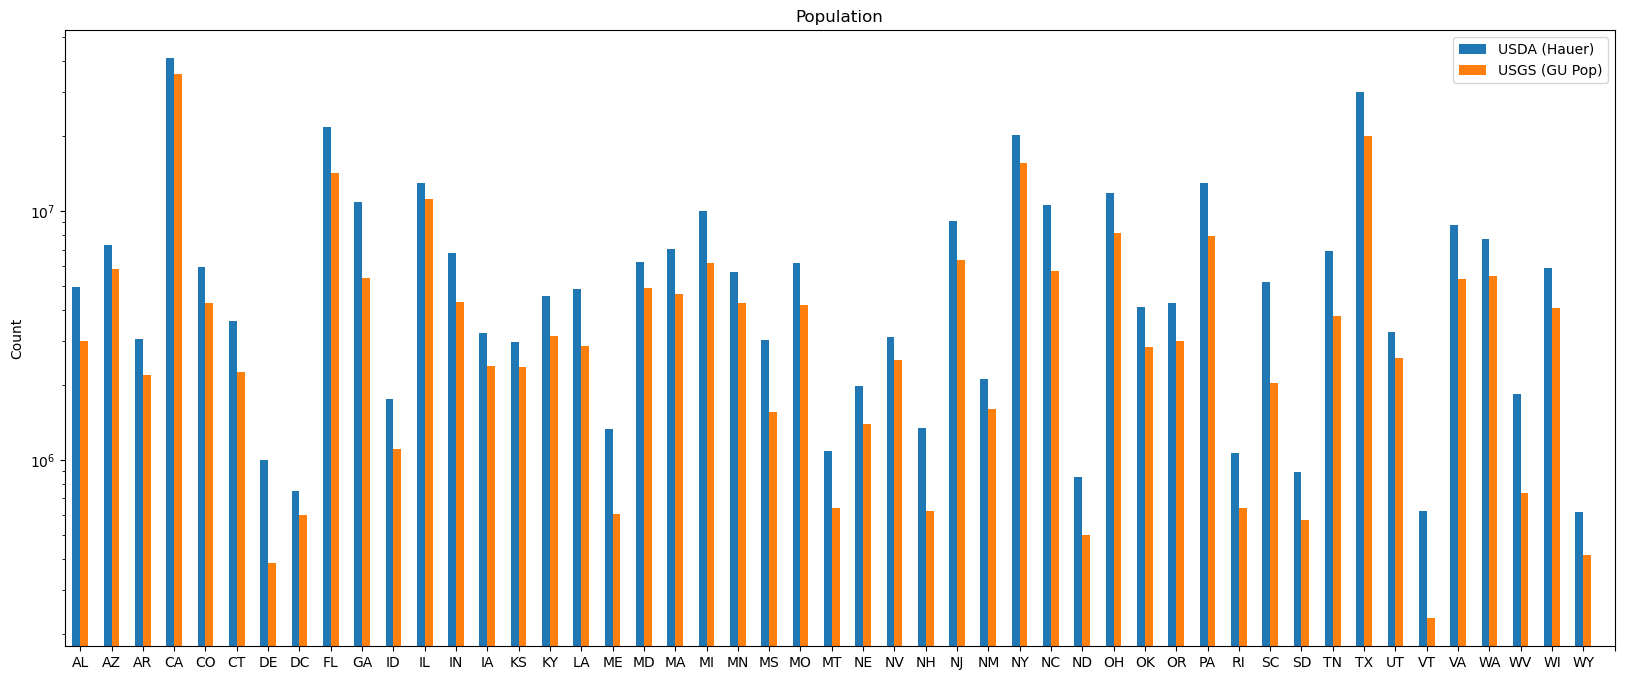

In [126]:
fig,ax = plt.subplots(figsize=(20,8))
x = np.arange(0,len(usda_demand_2020_state))*2

ax.bar(x-0.25,usda_demand_2020_state['ssp22020'],width = 0.5,label='USDA (Hauer)')
ax.bar(x+0.25, usgs_state['GU_POP'], width= 0.5,label='USGS (GU Pop)')
ax.legend()
ax.set_yscale('log')

ticklabels = ticklabels = np.concatenate(([' '],usda_demand_2020_state['abbv'],[' ']))
ax.set_xticklabels(ticklabels)
ax.xaxis.set_major_locator(plt.MaxNLocator(len(usda_demand_2020_state['abbv'])+1))
ax.set_xlim([-1,98])
# ax.set_ylim([0,1000])
ax.set_title('Population')
ax.set_ylabel('Count')

Old Code

In [13]:
# # Filtered for Treatment and include Facility Activity = Activity/Inactive
# sdwis_nofilter = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\SDWIS.csv',low_memory=False)
# sdwis_facilities_nofilter = pd.read_csv(r'C:\Users\mhardika\Documents\AMO\2050\analysis_files_2024\2020_WT_Facilities_Details.csv',low_memory=False)

# Filter for Facility activity = Active
# sdwis_filtered = sdwis_filtered[sdwis_filtered['Facility Activity']=='Active']

# sdwis_no_filter_pws_ids = sdwis_nofilter['PWS ID'].unique()
# sdwis_facilities_nofilter_pws_ids = sdwis_facilities_nofilter['PWS ID'].unique()
# print('Unique PWS_ID in SDWIS no filter:', len(sdwis_no_filter_pws_ids))
# print('Unique PWS_ID in SDWIS facilities no filter:', len(sdwis_facilities_nofilter_pws_ids))

In [14]:
# Trying to check if USGS WSA data set PWS IDs can be mapped to SDWIS No filter dataset

# usgs_check = usgs_gu_wwsa_df[['GU_ID','STATE_NAME','CNTY_NM','PLACE_FIPS','PLACE_NAME',
#                               'GU_POP','WTR_TYPE_E','PWS_ID','SELLER_PWS','WSA_AGIDF']]

# # Check if the PWS ID or Seller PWS ID is in the SDWIS dataset
# check_list = []
# pws_check_list = []

# for idx,row in usgs_check.iterrows():
#     if row['SELLER_PWS'] in sdwis_no_filter_pws_ids:
#         check_list.append('Yes')
#         pws_check_list.append(row['SELLER_PWS'])
#     elif row['PWS_ID'] in sdwis_no_filter_pws_ids:
#         check_list.append('Yes')
#         pws_check_list.append(row['PWS_ID'])
#     elif row['WSA_AGIDF'] in sdwis_no_filter_pws_ids:
#         check_list.append('Yes')
#         pws_check_list.append(row['WSA_AGIDF'])
#     else:
#         check_list.append('No')
#         pws_check_list.append(row['WSA_AGIDF'])

# usgs_check['pws_check'] = pws_check_list
# usgs_check['In SDWIS'] = check_list

# print('Number of facilities mapped to SDWIS no filter:', len(usgs_check[usgs_check['In SDWIS']=='Yes']))
# print('Number of unique PWS IDs:',len(usgs_check['pws_check'].unique()))

In [15]:
# Trying to check if USGS WSA data set PWS IDs can be mapped to SDWIS Facilities no filter dataset

# usgs_check = usgs_gu_wwsa_df[['GU_ID','PLACE_FIPS','PLACE_NAME','CNTY_NM', 'STATE_NAME','PWS_ID','SELLER_PWS','WSA_AGIDF']]

# # Check if the PWS ID or Seller PWS ID is in the SDWIS dataset
# check_list = []
# pws_check_list = []

# for idx,row in usgs_check.iterrows():
#     if row['SELLER_PWS'] in sdwis_facilities_nofilter_pws_ids:
#         check_list.append('Yes')
#         pws_check_list.append(row['SELLER_PWS'])
#     elif row['PWS_ID'] in sdwis_facilities_nofilter_pws_ids:
#         check_list.append('Yes')
#         pws_check_list.append(row['PWS_ID'])
#     elif row['WSA_AGIDF'] in sdwis_facilities_nofilter_pws_ids:
#         check_list.append('Yes')
#         pws_check_list.append(row['WSA_AGIDF'])
#     else:
#         check_list.append('No')
#         pws_check_list.append(row['WSA_AGIDF'])

# usgs_check['pws_check'] = pws_check_list
# usgs_check['In SDWIS'] = check_list

# print('Number of facilities mapped to SDWIS no filter:', len(usgs_check[usgs_check['In SDWIS']=='Yes']))
# print('Number of unique PWS IDs:',len(usgs_check['pws_check'].unique()))